# The Data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.
https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=icml_face_data.csv

## Preprocessing in one step

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

path = '../../../project_data/fer2013/icml_face_data.csv'
df = pd.read_csv(path)

# creating a dataframe that only contains training data
train = df[df[' Usage']=='Training'].copy()

# dropping the usage column
train.drop([' Usage'], axis = 1, inplace = True)

# combining public and private tests into a one dataframe
public = df[df[' Usage']=='PublicTest'].copy()
private = df[df[' Usage']=='PrivateTest'].copy()

# concatenating into one test dataframe
test = pd.concat([public, private])

# dropping usage column
test.drop([' Usage'], axis = 1, inplace = True)

# reseting the index
test.reset_index(inplace = True, drop = True)

def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into desired format
    return a numpy array
    '''

    reshaped_array = np.reshape(data[' pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

# def plot_random_images(dataset): 
#     if np.array_equal(dataset, train_images):
#         labels = train_labels
#     else:
#         labels = test_labels

#     # Checking 25 random images from the train set across all classes
#     plt.figure(figsize=(12,12))
#     for ind, img_num in enumerate(np.random.randint(1,len(dataset),size=25)):
#         plt.subplot(5,5,ind+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(dataset[img_num], cmap='gray')
#         plt.xlabel(emotions[labels[img_num]])
#     plt.show()
    

# extracting pixel values from the pixel column and scaling them between 0 and 1    
train[' pixels'] = train[' pixels'].apply(get_pixels_and_scale)   
test[' pixels'] = test[' pixels'].apply(get_pixels_and_scale)

# reshaping pixels column into a desired format and getting a numpy array
train_images = reshape_images(train)
test_images = reshape_images(test)

# getting the labels
train_labels = train['emotion']
test_labels = test['emotion']

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(28709, 48, 48, 1) (28709,)
(7178, 48, 48, 1) (7178,)


## Testing KNN with 3-20 neighbors

In [3]:
def flatten_images(data):
    '''
    reshape pixels column into desired format
    return a numpy array
    '''

    reshaped_array = np.reshape(data[' pixels'].to_list(),(data.shape[0],48*48))
    
    return reshaped_array

X_train = flatten_images(train)
y_train = train_labels

X_test = flatten_images(test)
y_test = test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28709, 2304) (28709,)
(7178, 2304) (7178,)


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

### Naively determining best K

In [5]:
# Creating a loop to test different numbers of neighbors
neighbors_params = [n for n in np.arange(3,21)]
obtained_accuracy = []
for n in neighbors_params: 
    # create a model
    model = KNeighborsClassifier(n_neighbors = n) 
    # fit on the training data, predict on test
    y_pred = model.fit(X_train, y_train).predict(X_test) 
    # check and record the accuracy 
    accuracy = accuracy_score(y_test, y_pred)    
    obtained_accuracy.append(accuracy)

In [6]:
# gather results in a dataframe
knn = pd.DataFrame({'n': neighbors_params, 'accuracy': obtained_accuracy})

In [7]:
knn.head()

,n,accuracy
0,3,0.338952
1,4,0.335887
2,5,0.337281
3,6,0.326693
4,7,0.325857


### Plot accuracy of each model against n_neighbors parameter

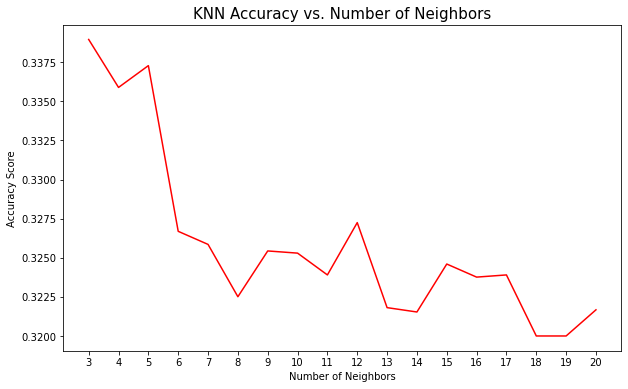

In [8]:
# Plot the accuracy against n_neighbors parameter
plt.figure(figsize=(10,6))
plt.plot(knn.n, knn.accuracy, color = 'red')
plt.title('KNN Accuracy vs. Number of Neighbors', size=15)
plt.xticks(knn.n)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Score')
plt.show()

### Performing 10-fold Cross Validation (testing 25 different Ks)

In [9]:
k_list = list(range(2,26))
cv_scores = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # Append avg score to the list
    cv_scores.append(scores.mean())

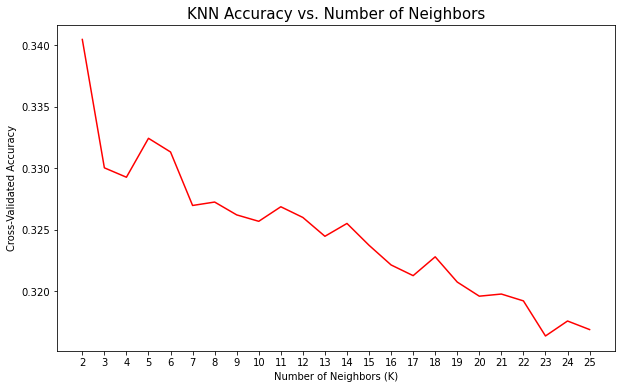

In [10]:
# Plot the cross-validated accuracy against n_neighbors parameter
plt.figure(figsize=(10,6))
plt.plot(k_list, cv_scores, color = 'red')
plt.title('KNN Accuracy vs. Number of Neighbors', size=15)
plt.xticks(k_list)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [11]:
cv_df = pd.DataFrame({'K': k_list, 'accuracy': cv_scores})
cv_df.head()

,K,accuracy
0,2,0.340485
1,3,0.330036
2,4,0.329270
3,5,0.332439
4,6,0.331325


In [12]:
# find index of the second best accuracy score
idx = cv_df['accuracy'].nlargest(2).idxmin()

#save in a variable
best_K = cv_df.iloc[idx,0]
print(f'The optimal number of neighbors based on 10-fold cross-validation is {best_K}')

The optimal number of neighbors based on 10-fold cross-validation is 5


In [13]:
knn_best  = KNeighborsClassifier(n_neighbors=best_K)
# fit on the training data, predict on test
y_pred = knn_best.fit(X_train, y_train).predict(X_test) 
# check and record the accuracy 
accuracy = accuracy_score(y_test, y_pred) 

#Calculating Model Accuracy
accuracy = accuracy_score(y_test, y_pred)*100.0
print(f'Accuracy of the best KNN model: {accuracy:.2f}%')

Accuracy of the best KNN model: 33.73%


In [14]:
# getting actual label names
y_pred_labels = np.array([emotions[i] for i in y_pred])
y_test_labels = np.array([emotions[i] for i in y_test])

### Plotting confusion matrix of the best model

In [15]:
# confusion matrix with integer-encoded labels
cm = confusion_matrix(y_test, y_pred)

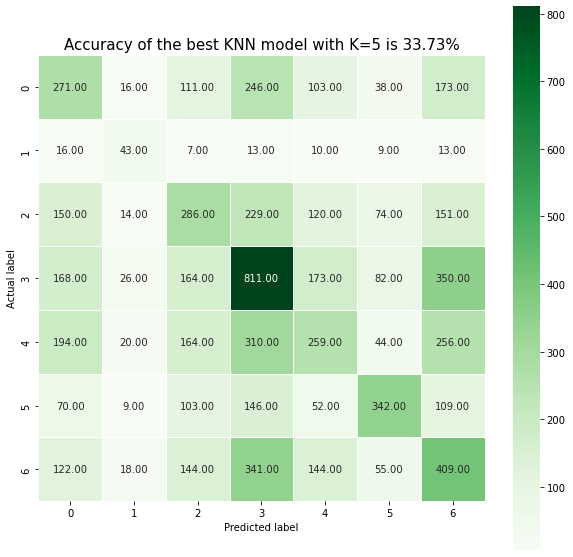

In [16]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt=".2f",
    linewidths=.5,
    square = True,
    cmap = 'Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title_text = 'Accuracy of the best KNN model with K={0} is {1}%'.format(best_K, "%.2f" % accuracy)
plt.title(title_text, size = 15)
plt.show()

### Plotting Normalized Confusion Matrix of the Best Model with Actual Label Names

[Text(0.5, 1.0, 'Accuracy of the best KNN model with K=5 is 33.73%'),
 Text(0.5, 0, 'Predicted Label'),
 Text(0, 0.5, 'Actual Label')]

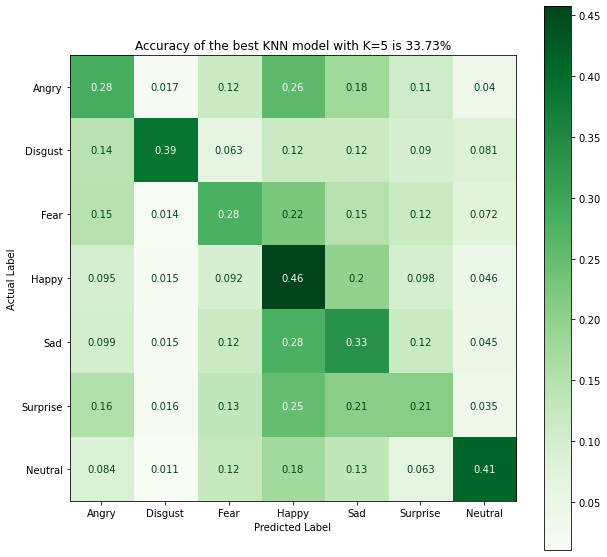

In [17]:
# confusion matrix with actual label names
cm_labels = confusion_matrix(y_test_labels, y_pred_labels)
# normalizing the values
cm_labels_norm = cm_labels.astype('float') / cm_labels.sum(axis=1)[:, np.newaxis]

cmd_obj = ConfusionMatrixDisplay(cm_labels_norm, display_labels=[i for i in emotions.values()])
fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax, cmap = 'Greens')

cmd_obj.ax_.set(
    title = 'Accuracy of the best KNN model with K={0} is {1}%'.format(5, "%.2f" % accuracy),
    xlabel='Predicted Label', 
    ylabel='Actual Label')

### SIFT

In [18]:
df_sift = pd.read_csv('../../../project_data/sift_data.csv')
df_sift.head()

,usage,emotion,histogram
0,train,3,4 3 6 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,2 8 4 4 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,2 9 9 5 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,2 3 3 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,6 14 7 2 1 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...


In [19]:
def load_data(df, sift):
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        if sift == 1:
            field = row.histogram
        else:
            field = row.pixels
        image = np.fromstring(field, dtype=int, sep=' ')
        scale = image / 255.0
        #image = np.reshape(image, (48, 48))
        image_data.append(image)
        image_scaled.append(scale)
        
#     return image_data, image_scaled
    return image_scaled

In [20]:
df_train = df_sift[df_sift['usage']=='train']
df_test = df_sift[df_sift['usage']=='test']
train_data = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [26]:
X_train_sift = np.array(train_data)
y_train = np.array(train_target)
X_test_sift = np.array(test_data)
y_test = np.array(test_target)

In [27]:
print(X_train_sift.shape)
print(y_train.shape)
print(X_test_sift.shape)
print(y_test.shape)

(28257, 29)
(28257,)
(7065, 29)
(7065,)


In [28]:
#Running KNN with K=5 on the SIFT data
knn_sift  = KNeighborsClassifier(n_neighbors=5)
# fit on the training data, predict on test
y_pred_sift = knn_sift.fit(X_train_sift, y_train).predict(X_test_sift)

#Calculating Model Accuracy
accuracy_sift = accuracy_score(y_test, y_pred_sift)*100.0
print(f'Accuracy of the best KNN model on the data trasfromed with SIFT is {accuracy_sift:.2f}%')

Accuracy of the best KNN model on the data trasfromed with SIFT is 19.45%
